<a href="https://colab.research.google.com/github/adrinorosario/stellar-and-galactic-object-classification/blob/main/SDSS_data_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SDSS Dataset Exploratory Data Ananlysis

Now, we will proceed with performing some Exploratory Data Analysis on the SDSS dataset obtained from the **[SDSS SkyServer DR18](https://skyserver.sdss.org/dr18/)** using the CASJobs web interface which can be found [here](https://skyserver.sdss.org/CasJobs/SubmitJob.aspx).

Documentation links:
* [Simple Guide - CASJobs](https://casjobs.sdss.org/casjobs/Guide.aspx)
* [About the SDSS SkyServer Database](https://skyserver.sdss.org/dr14/en/help/docs/intro.aspx#top)
* [SkyServer Database Schema Browser](https://skyserver.sdss.org/dr14/en/help/docs/intro.aspx#top)
* [SQL Cookbook for SDSS (DR18)](https://www.sdss.org/dr18/tutorials/)

Now, moving on to our goal of this notebook - **to perform some EDA and statistical testing on our data.**

The data was obtained by using the following SQL Query:

~~~~sql
SELECT TOP 5000
  p.objID,
  p.u, p.g, p.r, p.i, p.z,
  s.z as redshift,
  p.psfMag_u, p.psfMag_g, p.psfMag_r, p.psfMag_i, p.psfMag_z,
  p.modelMag_u, p.modelMag_g, p.modelMag_r, p.modelMag_i, p.modelMag_z,
  p.ra, p.dec,
  p.type,
  s.class, s.subclass
INTO mydb.QSO5000Sample
FROM PhotoObj as p
  JOIN SpecObj as s ON p.objID = s.bestObjID
WHERE s.class in ('QSO')
  AND p.r BETWEEN 14 AND 22
  ORDER BY s.class
~~~~

This is just one query that only retrieves the first 5000 records for Quasars (`QSO`).

## 1. Environment setup and data loading

We will load all the necessary packages required for performing exploratory data analysis. These include `pandas, nump, seaborn and matplotlib.pyplot`.

For statistical testing, we will use the `scipy.stats` library to leverage its prebuilt functions for statistical analyses.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

In [ ]:
# read in the CSV files
star_5000 = pd.read_csv("/content/Star5000Sample_adrino_0.csv")
galaxy_5000 = pd.read_csv("/content/Galaxy5000Sample_adrino_0.csv")
qso_5000 = pd.read_csv("/content/QSO5000Sample_adrino_0.csv")

In [ ]:
star_5000.head(5)

,objID,u,g,r,i,z,redshift,psfMag_u,psfMag_g,psfMag_r,...,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,ra,dec,type,class,subclass
0,1237659324957262195,21.60069,20.05125,19.41596,19.14403,19.13663,-0.000411,21.60731,20.02878,19.42174,...,21.60069,20.05125,19.41596,19.14403,19.13663,249.389880,36.138041,6,STAR,G8V (101501)
1,1237659329779990930,21.93001,21.91750,21.52963,21.27470,22.06409,-0.001336,21.70408,22.09389,21.74253,...,21.93001,21.91750,21.52963,21.27470,22.06409,249.260969,36.317375,6,STAR,A5Ia (17378)
2,1237665356156895340,24.35331,25.94455,21.84285,22.26830,23.32642,0.000009,24.27700,25.87515,21.91229,...,24.35331,25.94455,21.84285,22.26830,23.32642,244.688463,35.306784,6,STAR,F0II (25291)
3,1237665356157026743,21.78707,21.03528,20.75958,20.59272,20.57331,-0.001028,21.75583,21.02914,20.75499,...,21.78707,21.03528,20.75958,20.59272,20.57331,244.759436,35.642287,6,STAR,F2V (33256)
4,1237672795570307316,22.29189,21.39089,20.95556,20.78251,20.52724,-0.000739,22.26347,21.41386,20.99293,...,22.29189,21.39089,20.95556,20.78251,20.52724,1.795521,-5.193646,6,STAR,F6V (16673)


In [ ]:
galaxy_5000.head(5)

,objID,u,g,r,i,z,redshift,psfMag_u,psfMag_g,psfMag_r,...,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,ra,dec,type,class,subclass
0,1237648720679076369,23.10595,20.66453,18.96979,18.31188,17.78633,0.369197,25.14164,22.25788,20.56831,...,23.10595,20.66453,18.96979,18.31188,17.78633,146.192460,-0.508262,3,GALAXY,NaN
1,1237648721215881342,18.53085,16.56960,15.63575,15.19359,14.81316,0.036730,20.00671,18.09088,17.16710,...,18.53085,16.56960,15.63575,15.19359,14.81316,146.057304,-0.097030,3,GALAXY,NaN
2,1237661382236307764,24.34366,22.12065,20.57187,19.56820,18.98692,0.529718,24.23231,22.80094,21.26803,...,24.34366,22.12065,20.57187,19.56820,18.98692,148.055494,35.329555,3,GALAXY,NaN
3,1237661382773440711,19.70524,17.89358,16.71870,16.25648,15.86245,0.185496,22.13639,20.08626,18.83648,...,19.70524,17.89358,16.71870,16.25648,15.86245,148.459515,35.992702,3,GALAXY,NaN
4,1237662238021386587,19.25096,18.01749,17.47042,17.12019,16.88719,0.080418,21.38761,20.19293,19.79363,...,19.25096,18.01749,17.47042,17.12019,16.88719,226.819937,7.816179,3,GALAXY,STARFORMING


In [ ]:
qso_5000.head(5)

,objID,u,g,r,i,z,redshift,psfMag_u,psfMag_g,psfMag_r,...,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,ra,dec,type,class,subclass
0,1237648720672456843,19.09794,18.86200,18.62111,18.63129,18.50032,1.021404,19.09332,18.86416,18.61784,...,19.09794,18.86200,18.62111,18.63129,18.50032,131.084438,-0.452056,6,QSO,BROADLINE
1,1237648721209262485,19.37514,19.10271,19.04302,18.82779,18.83307,1.630802,19.35772,19.11467,19.05867,...,19.37514,19.10271,19.04302,18.82779,18.83307,131.003111,-0.160728,6,QSO,BROADLINE
2,1237648721209328431,23.17341,21.88116,21.17561,21.05995,20.49997,2.451194,23.16090,21.97578,21.27882,...,23.17341,21.88116,21.17561,21.05995,20.49997,131.074253,-0.064993,3,QSO,NaN
3,1237648721209393741,20.63601,20.63088,20.45119,20.61853,20.40845,0.974395,20.66001,20.64027,20.48331,...,20.63601,20.63088,20.45119,20.61853,20.40845,131.226257,-0.040683,6,QSO,NaN
4,1237648721746068071,21.49543,21.40450,21.24363,20.96151,21.05701,1.737630,21.49860,21.43789,21.26963,...,21.49543,21.40450,21.24363,20.96151,21.05701,130.882323,0.235083,6,QSO,NaN


## 2. Explore the datasets

Goals of this section:

1. Explore the 3 datasets and understand their composition and structure
2. Compute descriptive statistics and get a macro level understanding of all 3 datasets
3. What are the columns present in all 3 datasets? Are they consistent through all the 3 (stars, galaxies and quasars)?
4. Check for rows and columns with missing values.
5. Understand the nature of the missing values and decide the best method to deal with them (drop or replace?).

In [ ]:
star_5000.isna().sum()

,0
objID,0
u,0
g,0
r,0
i,0
z,0
redshift,0
psfMag_u,0
psfMag_g,0
psfMag_r,0


In [ ]:
galaxy_5000.isna().sum()

,0
objID,0
u,0
g,0
r,0
i,0
z,0
redshift,0
psfMag_u,0
psfMag_g,0
psfMag_r,0


In [ ]:
qso_5000.isna().sum()

,0
objID,0
u,0
g,0
r,0
i,0
z,0
redshift,0
psfMag_u,0
psfMag_g,0
psfMag_r,0


In [ ]:
na_subclass_count = int(qso_5000["subclass"].isna().sum() + galaxy_5000["subclass"].isna().sum())

In [ ]:
(na_subclass_count / (qso_5000.shape[0] + star_5000.shape[0] + galaxy_5000.shape[0])) * 100

38.2

From the above results, we can see that the `star_5000` dataframe does not have any missing values. However, the `galaxy_5000` and `qso_5000` have a lot of missing values, only in the *`subclass`* column. Since the proportion of missing values for `subclass` column is about 1/3 of our entire dataframe size, we will drop said column.

In [ ]:
star_5000 = star_5000.drop(["subclass"], axis=1)
qso_5000 = qso_5000.drop(["subclass"], axis=1)
galaxy_5000 = galaxy_5000.drop(["subclass"], axis=1)

"subclass" in star_5000.columns and "subclass" in qso_5000.columns and "subclass" in galaxy_5000.columns

False

In [ ]:
star_5000.describe()

,objID,u,g,r,i,z,redshift,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,ra,dec,type
count,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.237664e+18,20.983105,19.443456,18.763757,18.427835,18.267714,-0.000100,20.952586,19.471200,18.802698,18.462497,18.294069,20.983105,19.443456,18.763757,18.427835,18.267714,146.490668,23.358322,5.886600
std,7.504454e+12,2.214065,1.958088,1.796719,1.723584,1.759513,0.000429,2.167090,1.977960,1.825118,1.744392,1.768245,2.214065,1.958088,1.796719,1.723584,1.759513,92.615812,20.685816,0.572194
min,1.237646e+18,15.088220,14.589220,14.040450,13.843110,13.314760,-0.004136,15.090980,14.593500,14.035680,13.845560,13.732100,15.088220,14.589220,14.040450,13.843110,13.314760,0.118896,-11.241591,3.000000
25%,1.237659e+18,19.358235,18.021577,17.388787,17.127792,16.960275,-0.000274,19.364145,18.030213,17.412485,17.139250,16.976103,19.358235,18.021577,17.388787,17.127792,16.960275,50.355142,4.364063,6.000000
50%,1.237662e+18,20.544855,19.176335,18.686100,18.434175,18.209865,-0.000062,20.553370,19.189630,18.704805,18.448795,18.222985,20.544855,19.176335,18.686100,18.434175,18.209865,140.173407,23.553033,6.000000
75%,1.237668e+18,22.643088,21.110895,20.333603,19.791942,19.491727,0.000091,22.603495,21.135948,20.388668,19.933872,19.566715,22.643088,21.110895,20.333603,19.791942,19.491727,216.124027,41.315350,6.000000
max,1.237681e+18,27.325760,26.788130,21.999810,24.612700,24.437550,0.004037,27.119100,25.875150,23.546310,24.364470,23.261120,27.325760,26.788130,21.999810,24.612700,24.437550,359.780950,59.478925,6.000000


In [ ]:
galaxy_5000.describe()

,objID,u,g,r,i,z,redshift,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,ra,dec,type
count,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.237664e+18,22.192955,20.458296,19.171728,18.491020,18.101367,0.367183,22.891221,21.527354,20.331401,19.669112,19.224460,22.192955,20.458296,19.171728,18.491020,18.101367,171.864315,17.963310,3.128400
std,7.274865e+12,2.365624,2.177941,1.863473,1.671610,1.622577,0.258732,1.614162,1.721076,1.467598,1.270852,1.217219,2.365624,2.177941,1.863473,1.671610,1.622577,61.063763,14.172616,0.607279
min,1.237649e+18,15.028880,14.822180,14.052380,13.483800,12.997580,-0.007743,17.516060,16.662970,15.953890,15.667650,15.311360,15.028880,14.822180,14.052380,13.483800,12.997580,1.256416,-9.019794,3.000000
25%,1.237658e+18,20.097198,18.382950,17.506952,17.078337,16.773202,0.119240,21.493805,19.911095,19.060723,18.623323,18.274040,20.097198,18.382950,17.506952,17.078337,16.773202,135.076628,6.021979,3.000000
50%,1.237664e+18,22.476855,21.092510,19.460895,18.749205,18.315630,0.351041,23.126565,21.928105,20.510185,19.876180,19.442615,22.476855,21.092510,19.460895,18.749205,18.315630,160.050522,14.016315,3.000000
75%,1.237668e+18,23.978775,22.217845,20.757790,19.782540,19.318160,0.555155,24.137590,22.915945,21.566715,20.608170,20.087025,23.978775,22.217845,20.757790,19.782540,19.318160,219.558114,29.824520,3.000000
max,1.237681e+18,27.679830,26.121010,21.999770,23.998550,24.080750,1.951209,26.816220,25.929910,23.582110,24.291330,23.727740,27.679830,26.121010,21.999770,23.998550,24.080750,359.678397,53.857765,6.000000


In [ ]:
qso_5000.describe()

,objID,u,g,r,i,z,redshift,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,ra,dec,type
count,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.237664e+18,21.438928,20.929627,20.628227,20.438150,20.297422,1.638804,21.439389,20.993848,20.708841,20.517853,20.360737,21.438928,20.929627,20.628227,20.438150,20.297422,178.082404,25.564012,5.793000
std,9.340167e+12,1.331747,1.067077,0.988035,0.987484,1.021699,0.820895,1.287975,1.088249,0.993574,0.965338,0.969720,1.331747,1.067077,0.988035,0.987484,1.021699,91.883695,17.340344,0.760438
min,1.237649e+18,16.612720,15.144840,14.292350,14.077170,13.823710,0.019425,16.754500,16.650840,16.496990,16.273750,15.999910,16.612720,15.144840,14.292350,14.077170,13.823710,0.299074,-10.997950,3.000000
25%,1.237657e+18,20.664568,20.335010,20.081375,19.898875,19.717265,1.110972,20.676022,20.364300,20.128900,19.966213,19.800277,20.664568,20.335010,20.081375,19.898875,19.717265,130.576201,5.563070,6.000000
50%,1.237664e+18,21.450820,21.097030,20.828560,20.597815,20.408360,1.548765,21.453700,21.140175,20.869055,20.671935,20.460780,21.450820,21.097030,20.828560,20.597815,20.408360,150.773271,30.013170,6.000000
75%,1.237669e+18,22.106357,21.657035,21.383735,21.159903,21.008187,2.047457,22.093388,21.708172,21.453340,21.235105,21.055185,22.106357,21.657035,21.383735,21.159903,21.008187,249.682886,39.206891,6.000000
max,1.237681e+18,27.434460,26.793170,21.999090,24.450260,23.850270,7.011245,26.109630,26.058680,23.694450,24.327310,23.768770,27.434460,26.793170,21.999090,24.450260,23.850270,359.809734,65.163409,6.000000


Now, we need to compute the colour indices. These are important parameters that help us in determining the **colour** of celestial bodies and in our case, will help us in classifying between the 3 bodies.

The important colour indicies we require are :
* $u-g$
* $g-r$
* $r-i$
* $i-z$

For calculating the colour indicies of stars, we will use the `psfMag` or `Point Spread Function Magnitudes` columns. For galaxies and quasars, we will use the `modelMag` or `Model Magnitudes`. The reason for choosing these columns distinctly is explained below.

$\to$ **Choosing Point Spread Function Magnitudes (`psfMag`) for Stars and Model Magnitudes (`modelMag`) for Galaxies and Quasars**

* The *Point Spread Function Magnitude (`psfMag`)* is an effective measurement for calucaulting the colour indices of stars and quasars mainly due to its apparent nature of being recorded by fitting a PSF model to the light distribtuion of the object.

  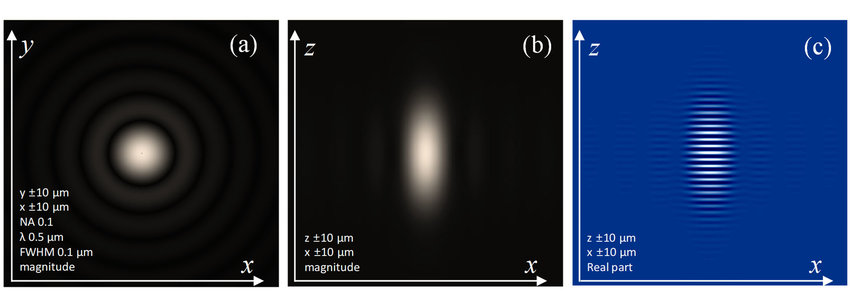
  
  [Image uploaded by Peter J. DE Groot](https://www.researchgate.net/figure/a-Magnitude-of-the-2D-PSF-in-the-x-y-plane-b-An-x-z-cross-section-of-the_fig3_335677224)

  The `psfMag` measures the true apprearance of the point after it is blurred by the telescope optics and the atmosphere. Stars are effectively point sources observed by the SDSS at a distance. Quasars are on the other-hand, are also more point-like yet unresolved in some imaging.

* In the case of galaxies, the *Model Mangitude (`modelMag`)* is obtained by fitting the light distribution of the spiral galaxies disks or elliptical galaxies to the object's light. The fitting is done primarily in the r-band and the result is taken to measure the magnitude in all other bands. This is recommended and better suited for galaxies because it helps in better studying the colours by providing a consistent aperture across all the bands. For quasars,



In [ ]:
star_5000["u_g"] = star_5000["psfMag_u"] - star_5000["psfMag_g"]
star_5000["g_r"] = star_5000["psfMag_g"] - star_5000["psfMag_r"]
star_5000["r_i"] = star_5000["psfMag_r"] - star_5000["psfMag_i"]
star_5000["i_z"] = star_5000["psfMag_i"] - star_5000["psfMag_z"]

In [ ]:
galaxy_5000["u_g"] = galaxy_5000["modelMag_u"] - galaxy_5000["modelMag_g"]
galaxy_5000["g_r"] = galaxy_5000["modelMag_g"] - galaxy_5000["modelMag_r"]
galaxy_5000["r_i"] = galaxy_5000["modelMag_r"] - galaxy_5000["modelMag_i"]
galaxy_5000["i_z"] = galaxy_5000["modelMag_i"] - galaxy_5000["modelMag_z"]

In [ ]:
qso_5000["u_g"] = qso_5000["psfMag_u"] - qso_5000["psfMag_g"]
qso_5000["g_r"] = qso_5000["psfMag_g"] - qso_5000["psfMag_r"]
qso_5000["r_i"] = qso_5000["psfMag_r"] - qso_5000["psfMag_i"]
qso_5000["i_z"] = qso_5000["psfMag_i"] - qso_5000["psfMag_z"]

In [ ]:
star_5000.head(3)

,objID,u,g,r,i,z,redshift,psfMag_u,psfMag_g,psfMag_r,...,modelMag_i,modelMag_z,ra,dec,type,class,u_g,g_r,r_i,i_z
0,1237659324957262195,21.60069,20.05125,19.41596,19.14403,19.13663,-0.000411,21.60731,20.02878,19.42174,...,19.14403,19.13663,249.389880,36.138041,6,STAR,1.57853,0.60704,0.28251,0.00578
1,1237659329779990930,21.93001,21.91750,21.52963,21.27470,22.06409,-0.001336,21.70408,22.09389,21.74253,...,21.27470,22.06409,249.260969,36.317375,6,STAR,-0.38981,0.35136,0.30114,-0.66418
2,1237665356156895340,24.35331,25.94455,21.84285,22.26830,23.32642,0.000009,24.27700,25.87515,21.91229,...,22.26830,23.32642,244.688463,35.306784,6,STAR,-1.59815,3.96286,-0.46447,-0.88436


In [ ]:
qso_5000.head(3)

,objID,u,g,r,i,z,redshift,psfMag_u,psfMag_g,psfMag_r,...,modelMag_i,modelMag_z,ra,dec,type,class,u_g,g_r,r_i,i_z
0,1237648720672456843,19.09794,18.86200,18.62111,18.63129,18.50032,1.021404,19.09332,18.86416,18.61784,...,18.63129,18.50032,131.084438,-0.452056,6,QSO,0.23594,0.24089,-0.01018,0.13097
1,1237648721209262485,19.37514,19.10271,19.04302,18.82779,18.83307,1.630802,19.35772,19.11467,19.05867,...,18.82779,18.83307,131.003111,-0.160728,6,QSO,0.27243,0.05969,0.21523,-0.00528
2,1237648721209328431,23.17341,21.88116,21.17561,21.05995,20.49997,2.451194,23.16090,21.97578,21.27882,...,21.05995,20.49997,131.074253,-0.064993,3,QSO,1.29225,0.70555,0.11566,0.55998


In [ ]:
galaxy_5000.head(3)

,objID,u,g,r,i,z,redshift,psfMag_u,psfMag_g,psfMag_r,...,modelMag_i,modelMag_z,ra,dec,type,class,u_g,g_r,r_i,i_z
0,1237648720679076369,23.10595,20.66453,18.96979,18.31188,17.78633,0.369197,25.14164,22.25788,20.56831,...,18.31188,17.78633,146.192460,-0.508262,3,GALAXY,2.44142,1.69474,0.65791,0.52555
1,1237648721215881342,18.53085,16.56960,15.63575,15.19359,14.81316,0.036730,20.00671,18.09088,17.16710,...,15.19359,14.81316,146.057304,-0.097030,3,GALAXY,1.96125,0.93385,0.44216,0.38043
2,1237661382236307764,24.34366,22.12065,20.57187,19.56820,18.98692,0.529718,24.23231,22.80094,21.26803,...,19.56820,18.98692,148.055494,35.329555,3,GALAXY,2.22301,1.54878,1.00367,0.58128


## 3. Exploratory Data Analysis and Statistical Testing

The objectives of this section are as follows:

* Perform EDA on the dataset
* Understand the characteristics of the parameters important for classification
* Test out hypotheses and claims

First, we will combine all 3 datasets into one single dataset.

In [ ]:
df = pd.concat([star_5000, galaxy_5000, qso_5000])
df

,objID,u,g,r,i,z,redshift,psfMag_u,psfMag_g,psfMag_r,...,modelMag_i,modelMag_z,ra,dec,type,class,u_g,g_r,r_i,i_z
0,1237659324957262195,21.60069,20.05125,19.41596,19.14403,19.13663,-0.000411,21.60731,20.02878,19.42174,...,19.14403,19.13663,249.389880,36.138041,6,STAR,1.57853,0.60704,0.28251,0.00578
1,1237659329779990930,21.93001,21.91750,21.52963,21.27470,22.06409,-0.001336,21.70408,22.09389,21.74253,...,21.27470,22.06409,249.260969,36.317375,6,STAR,-0.38981,0.35136,0.30114,-0.66418
2,1237665356156895340,24.35331,25.94455,21.84285,22.26830,23.32642,0.000009,24.27700,25.87515,21.91229,...,22.26830,23.32642,244.688463,35.306784,6,STAR,-1.59815,3.96286,-0.46447,-0.88436
3,1237665356157026743,21.78707,21.03528,20.75958,20.59272,20.57331,-0.001028,21.75583,21.02914,20.75499,...,20.59272,20.57331,244.759436,35.642287,6,STAR,0.72669,0.27415,0.17229,0.01086
4,1237672795570307316,22.29189,21.39089,20.95556,20.78251,20.52724,-0.000739,22.26347,21.41386,20.99293,...,20.78251,20.52724,1.795521,-5.193646,6,STAR,0.84961,0.42093,0.19129,0.31537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1237678824098038460,21.20652,21.06583,20.78998,20.76210,20.30957,1.449921,21.19287,21.06549,20.77686,...,20.76210,20.30957,326.640907,3.110061,6,QSO,0.12738,0.28863,-0.02096,0.47329
4996,1237678824098103662,20.34307,20.16098,20.00920,19.76901,19.71872,1.918691,20.31214,20.17169,20.01063,...,19.76901,19.71872,326.741748,3.249749,6,QSO,0.14045,0.16106,0.21978,0.07393
4997,1237678824098103837,21.22289,20.81043,20.55345,20.37359,20.01987,1.622797,21.22987,20.82619,20.54190,...,20.37359,20.01987,326.662817,3.251487,6,QSO,0.40368,0.28429,0.14113,0.37840
4998,1237678824098103847,20.64742,20.33724,20.02773,20.02608,19.99317,1.111624,20.59321,20.37671,20.07022,...,20.02608,19.99317,326.678107,3.181776,6,QSO,0.21650,0.30649,-0.02287,0.07142


In [ ]:
df.to_csv("/content/drive/MyDrive/sdss_15k_sample.csv", index=False)

<Axes: xlabel='redshift', ylabel='class'>

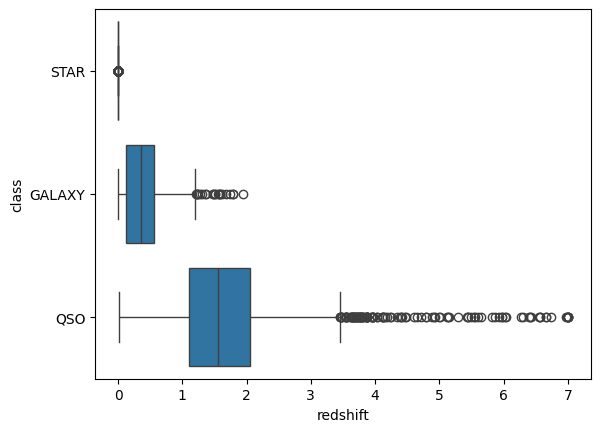

In [ ]:
sns.boxplot(data=df, x="redshift", y="class")

We can observe the following from the above boxplot:

* The `redshift` of stars does not seem to contain a significant number of outliers.
* In the case of galaxies, there do appear to be a significant number of outliers as indicated by the above boxplot.
* Quasars, have the most number of outliers for `redshift`; almost half of the `redshift` values appear to be outliers.

**Understanding `redshift` and its significance in astronomy**

Redshift is redfined as the spread of electromagnetic wavelenghts such as that of light when travelling through space.

The following points should help in understanding it better:

* When a body is moving away from us, the redshift is stretched and is wider due to the greater distance it needs to travel.
* When a body is moving towards us, the redshift is compressed and narrower due to the less distance it needs to travel.

Redshift is also used to measure the distance to cosmic bodies and looking back in time.

**Importance of `redshift` for our problem**

Redshift helps us in identifying and classifying whether the particular observed body is a star, galaxy or quasar. The observation of redshift for these 3 bodies is affected by the expansion of space and the distance of these bodies from us.

* The stars observed are typically located in our Milky Way galaxy and therefore are not that farther away as compared to other galaxies and quasars. Therefore, the `redshift` of stars is typically close to zero.

  * **Stars:** Colours are primarily determined by temperature. Redshift is low and almost 0 or negative ($z ≈ 0$).

* Galaxies, on the other hand are inter-gallactic bodies and thier distance from us also adheres to the same. Therefore, the light perceived of them is a collection of the light produced by all its stars along with some cosmic dust and gas. Their observed cosmological `redshift` is affected by the expansion of the universe. Therefore, their redshift is higher than that of stars.

  * **Galaxies:** Colours are determined by the collective light emitted by stars and cosmic dust and gas, which significantly alter its redshift. Have moderate redshifts.

* Quasars on the other hand are the most farthest in existence, in the center of the farthest galaxies. Though they appear sometimes to be as bright as local stars, their redshift is the highest of the 3 bodies owing to the sheer stellar distance it takes for thier light to reach us.

  * **Quasars:** Colour determined by non-thermal SED's and high redshifts ($z \geq 0.5$).

<Axes: xlabel='redshift', ylabel='Count'>

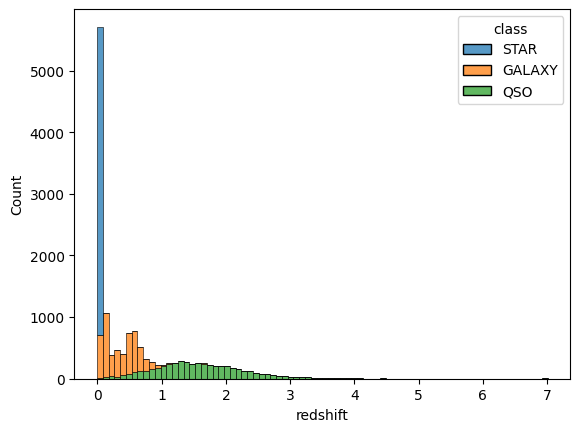

In [ ]:
sns.histplot(data=df, x="redshift", hue="class", multiple="stack")

We can see that the data for `redshift` in our dataset is heavily right skewed. Fruthermore, when distinguished using a grouped histogram, we can see that the concentration does not exceed beyond 0 for stars but is a bit more spread across for galaxies and quasars.

Galxies again seem to be a bit more right skewed while quasars have a normal distribution from this high level overview.

<Axes: xlabel='redshift', ylabel='Count'>

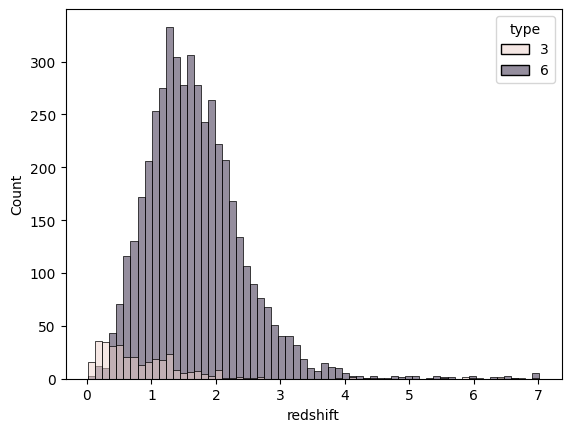

In [ ]:
sns.histplot(data=qso_5000, x="redshift", hue="type")

<Axes: xlabel='redshift', ylabel='Count'>

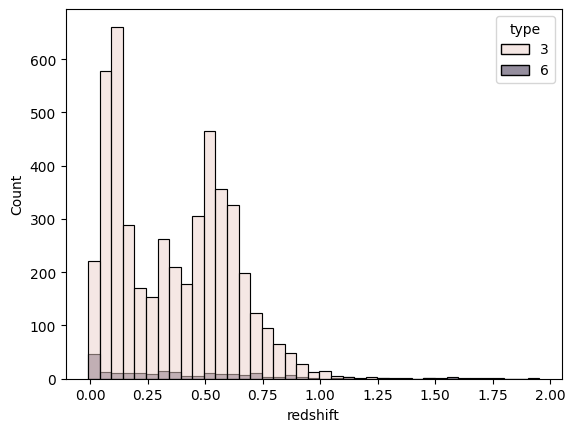

In [ ]:
sns.histplot(data=galaxy_5000, x="redshift", hue="type")

From the above visualizations, we can observe that the distribution of `redshift` for quasars is more right-skewed compared to that of galaxies.

$\to$ For quasars, the major concentration of `redshift` lies approximately between 0.5 and 3.0; in the case of galaxies, the major concentration is between 0.0 and 0.80, almost close to 1.0 but not very much.

The `redshift` of stars is pretty much 0. Confirming it with a histogram below, we can see the majority concentration lies between -0.001 and 0.001

<Axes: xlabel='redshift', ylabel='Count'>

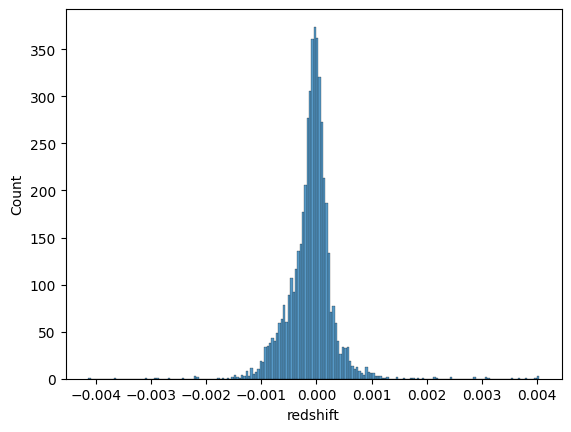

In [ ]:
sns.histplot(data=star_5000, x="redshift")

Using the below stripplot, we can clearly visualize the spread of redshift values among each classes and within their respective types.

<Axes: xlabel='class', ylabel='redshift'>

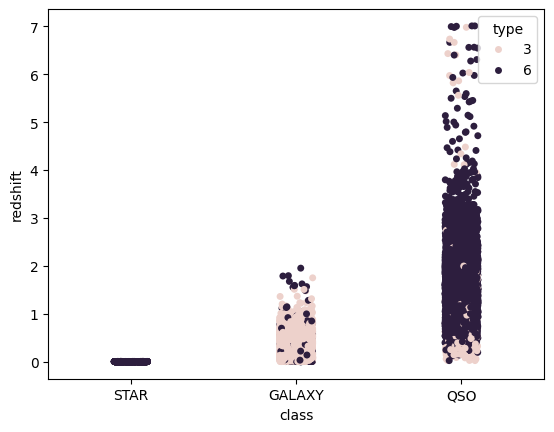

In [ ]:
sns.stripplot(data=df, x="class", y="redshift", hue="type")

### 3.1 Hypothesis Testing

As seen above, we can see that redshift of stars is clearly smaller comapared to those of galaxies and quasars, with quasars having the greatest redshift values.

Now, we will coduct a few hypothesis tests to see if that is statistically significant or true. To be precise, we will conduct hyposthesis tests to test the following claim:

$ star\ redshift < galaxy\ redshift < qso\ redshift $

In [ ]:
mean_star_redshift = star_5000["redshift"].mean()
mean_galaxy_redshift = galaxy_5000["redshift"].mean()
mean_qso_redshift = qso_5000["redshift"].mean()

print(f"Mean redshift in stars: {mean_star_redshift}")
print(f"Mean redshift in galaxies: {mean_galaxy_redshift}")
print(f"Mean redshift in quasars: {mean_qso_redshift}")

Mean redshift in stars: -0.00010005301443822801
Mean redshift in galaxies: 0.367182916163768
Mean redshift in quasars: 1.63880374901


In [ ]:
mean_star_redshift < mean_galaxy_redshift < mean_qso_redshift

np.True_

***Hypothesis Test 1***

*Hypothesis*: The mean observed `redshift` value for stars is significantly lesser than those observed for galaxies.

$H_0$: There is no significant difference between the observed `redshift` for stars as those observed for galaxies.

$H_1$: `redshift` observed for galaxies is significantly greater than those observed for stars.

In [25]:
df = pd.read_csv("/content/drive/MyDrive/sdss_15k_sample.csv")

In [26]:
star_redshift = df.loc[df["class"]=="STAR", "redshift"]
galaxy_redshift = df.loc[df["class"]=="GALAXY", "redshift"]

The significance level is set to be $5\%$.

In [27]:
# significance level is 5%
sig_level = 0.05

In [28]:
def mean_diff(a, b):
  return np.mean(a) - np.mean(b)

In [29]:
p_val_stat = stats.permutation_test(
    (star_redshift, galaxy_redshift),
    statistic=mean_diff,
    permutation_type="independent",
    n_resamples=5000,
    alternative="two-sided",
    random_state=42
)

p_val_stat.pvalue < sig_level, p_val_stat.pvalue

(np.True_, np.float64(0.0003999200159968006))

From the above hypothesis test, we can clearly see that our p-value is lesser than the significance level. Therfore, we can reject the null hypothesis in favour of the alternate hypothesis.

Therefore, there is a significant difference in the redshifts of stars compared to that of galaxies, with galaxies having higher mean redshift values than stars.

***Hypothesis Test 2***

*Hypothesis*: The mean observed `redshift` for quasars is higher than the mean observed `redshift` of galaxies.

$H_0$: The `redshift` of galaxies is almost equal or lesser than that of quasars.

$H_1$: The `redshift` observed for quasars is higher than that observed for galaxies.

In [30]:
qso_redshift = df.loc[df["class"]=="QSO", "redshift"]

Significance level remains at $5\%$.

In [31]:
p_val_stat = stats.permutation_test(
    (galaxy_redshift, qso_redshift),
    statistic=mean_diff,
    permutation_type="independent",
    n_resamples=5000,
    alternative="two-sided",
    random_state=42
)

p_val_stat.pvalue < sig_level, p_val_stat.pvalue

(np.True_, np.float64(0.0003999200159968006))

From the above hypothesis test, we can clearly see that our p-value is lesser than the significance level. Therfore, we can reject the null hypothesis in favour of the alternate hypothesis.

Therefore, the `redshift` observed for quasars is higher than that observed for galaxies.

## 4. Splitting data into train and test splits

Now, we are going to spilt our data into training and testing splits so that they can be fed into the model in an appropriate format. We are going to use and apply different methods and techniques to get a good train and test split.

The objectives of this section:
* Identify the necessary parameters (columns) that are needed for training and testing
* Using different techniques and arrive at 3 different sets of train and test sets
* Save/cache the splits

In [ ]:
pd.DataFrame(df.columns)

,0
0,objID
1,u
2,g
3,r
4,i
5,z
6,redshift
7,psfMag_u
8,psfMag_g
9,psfMag_r


We have 24 columns above but we really do not need all of them. For our problem we are going to stick to the following parameters:

* Photometric data : $u, g, r, i, z$
* Spectral data: $redshift$
* Colour indicies: $u\_g, g\_r, r\_i, i\_z$
* Labels: $class$ (`target`)

These are the most important features that are required and fundamental for our problem of predictive classification.

Hence, we will create a seperate dataframe that only holds these columsn while omitting the others.

In [ ]:
final_df = df.filter(["u", "g", "r", "i", "z", "u_g", "g_r", "r_i", "i_z", "redshift", "class"])
final_df.shape

(15000, 11)

In [ ]:
final_df.head(3)

,u,g,r,i,z,u_g,g_r,r_i,i_z,redshift,class
0,21.60069,20.05125,19.41596,19.14403,19.13663,1.57853,0.60704,0.28251,0.00578,-0.000411,STAR
1,21.93001,21.91750,21.52963,21.27470,22.06409,-0.38981,0.35136,0.30114,-0.66418,-0.001336,STAR
2,24.35331,25.94455,21.84285,22.26830,23.32642,-1.59815,3.96286,-0.46447,-0.88436,0.000009,STAR


In [ ]:
final_df["class"].unique()

array(['STAR', 'GALAXY', 'QSO'], dtype=object)

In [ ]:
final_df.value_counts(["class"])

,count
class,
GALAXY,5000
QSO,5000
STAR,5000


Awesome! We now have our dataset which can be split into its training and testing splits.

### 4.1 Creating train and test splits

**Note:** The `class` first needs to be encoded as strings are not supported to be target (`y`) values. We will use one-hot encoding method to convert them into numerical format and then create our splits.

In [ ]:
encoder = {
    "STAR": 0,
    "GALAXY": 1,
    "QSO": 2
}

final_df["class"] = final_df["class"].map(encoder)
final_df["class"].value_counts()

,count
class,
0,5000
1,5000
2,5000


In [ ]:
X = final_df.drop(['class'], axis=1)
X.columns

Index(['u', 'g', 'r', 'i', 'z', 'u_g', 'g_r', 'r_i', 'i_z', 'redshift'], dtype='object')

In [ ]:
y = final_df["class"]
y.value_counts()

,count
class,
0,5000
1,5000
2,5000


Sweet! Now we can create our splits.

The `class` column will be our `y` or **target variable**, often called the **label**. The rest of the columns will be our `X` **features** or **parameter variables** that our model will learn from.

We will create 3 sets of train and test splits of the following ratios:

* 80:20 (80% training and 20% testing) - popular and widely used; balances training with sufficient testing.

* 67:33 (67% training and 33% testing) - used when you have a large dataset and want to maximize model learning

* 90:10 (90% training and 10% testing) - more emphasis on training while still having a sufficient proportion for testing.

***Note:*** Each split ratio has its own pros and cons. It highly depends on the nature of the dataset you are dealing with.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# 80:20 split
X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training features set has {X_train_80.shape[0]} rows with {X_train_80.shape[1]} columns")
print(f"Training labels set has {y_train_80.shape[0]} rows\n")

print(f"Testing features set has {X_test_80.shape[0]} rows with {X_test_80.shape[1]} columns")
print(f"Testing labels set has {y_test_80.shape[0]} rows")

Training features set has 12000 rows with 10 columns
Training labels set has 12000 rows

Testing features set has 3000 rows with 10 columns
Testing labels set has 3000 rows


In [ ]:
# 67:33 split
X_train_67, X_test_67, y_train_67, y_test_67 = train_test_split(
    X, y, test_size=0.33, stratify=y, random_state=42
)
X_train_67.shape, y_train_67.shape

print(f"Training features set has {X_train_67.shape[0]} rows with {X_train_67.shape[1]} columns")
print(f"Training labels set has {y_train_67.shape[0]} rows\n")

print(f"Testing features set has {X_test_67.shape[0]} rows with {X_test_67.shape[1]} columns")
print(f"Testing labels set has {y_test_67.shape[0]} rows")

Training features set has 10050 rows with 10 columns
Training labels set has 10050 rows

Testing features set has 4950 rows with 10 columns
Testing labels set has 4950 rows


In [ ]:
# 90:10 split
X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

print(f"Training features set has {X_train_90.shape[0]} rows with {X_train_90.shape[1]} columns")
print(f"Training labels set has {y_train_90.shape[0]} rows\n")

print(f"Testing features set has {X_test_90.shape[0]} rows with {X_test_90.shape[1]} columns")
print(f"Testing labels set has {y_test_90.shape[0]} rows")

Training features set has 13500 rows with 10 columns
Training labels set has 13500 rows

Testing features set has 1500 rows with 10 columns
Testing labels set has 1500 rows


We will save our splits locally.

In [ ]:
import joblib

In [ ]:
joblib.dump([X_train_80, X_test_80, y_train_80, y_test_80], "/content/drive/MyDrive/sdss_5000_train_test_split_80.joblib")
joblib.dump([X_train_67, X_test_67, y_train_67, y_test_67], "/content/drive/MyDrive/sdss_5000_train_test_split_67.joblib")
joblib.dump([X_train_90, X_test_90, y_train_90, y_test_90], "/content/drive/MyDrive/sdss_5000_train_test_split_90.joblib")

['/content/drive/MyDrive/sdss_5000_train_test_split_90.joblib']

# Comparing data with different samples

Now, from the above findings, we can see that the dataset has a lot of noise and outliers, especially in the `redshift` values for the different bodies. Initially, the data was queried using the following query:

~~~~sql
SELECT TOP 5000
  p.objID,
  p.u, p.g, p.r, p.i, p.z,
  s.z as redshift,
  p.psfMag_u, p.psfMag_g, p.psfMag_r, p.psfMag_i, p.psfMag_z,
  p.modelMag_u, p.modelMag_g, p.modelMag_r, p.modelMag_i, p.modelMag_z,
  p.ra, p.dec,
  p.type,
  s.class, s.subclass
INTO mydb.QSO5000Sample
FROM PhotoObj as p
  JOIN SpecObj as s ON p.objID = s.bestObjID
WHERE s.class in ('QSO')
  AND p.r BETWEEN 14 AND 22
  ORDER BY s.class
~~~~

In this, we did not use:
~~~~sql
ORDER BY p.r
~~~~
This gave us records with a range of magnitudes and **not only the brightest objects**. It might be the case that since we even have fainter objects (not entirely faint or extremely faint), they contribute to the amount of noise and outliers. Therefore, we have now queried another sample where we order records by the brightness in the red magnitude/filter (`p.r`). The dataset used in this part of the notebook was queried using the following query:

~~~~sql
SELECT TOP 5000
  p.objID,
  p.u, p.g, p.r, p.i, p.z,
  s.z as redshift,
  p.psfMag_u, p.psfMag_g, p.psfMag_r, p.psfMag_i, p.psfMag_z,
  p.modelMag_u, p.modelMag_g, p.modelMag_r, p.modelMag_i, p.modelMag_z,
  p.ra, p.dec,
  p.type,
  s.class, s.subclass
INTO mydb.QSO5000Sample
FROM PhotoObj as p
  JOIN SpecObj as s ON p.objID = s.bestObjID
WHERE s.class in ('QSO')
  AND p.r BETWEEN 14 AND 22
  ORDER BY p.r, s.class -- ordering by brightness in red filter
~~~~

Now, we will perform some EDA on this dataset and compare the two and decide whether to move forward with this dataset or stick to the previous one.

In this part of the notebook, we will:

1. Check the class proportions and handle missing values and outliers.
2. Perform EDA on the new dataset.
3. Compare and analyse `r` and `redshift` values of both the datasets side by side.
4. Perform some statistical testing on the new dataset.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

We will load even the previous dataset for side-by-side comparison.

In [3]:
df_A = pd.read_csv("/content/drive/MyDrive/sdss_15k_sample.csv")
df_A.head(5)

,objID,u,g,r,i,z,redshift,psfMag_u,psfMag_g,psfMag_r,...,modelMag_i,modelMag_z,ra,dec,type,class,u_g,g_r,r_i,i_z
0,1237659324957262195,21.60069,20.05125,19.41596,19.14403,19.13663,-0.000411,21.60731,20.02878,19.42174,...,19.14403,19.13663,249.389880,36.138041,6,STAR,1.57853,0.60704,0.28251,0.00578
1,1237659329779990930,21.93001,21.91750,21.52963,21.27470,22.06409,-0.001336,21.70408,22.09389,21.74253,...,21.27470,22.06409,249.260969,36.317375,6,STAR,-0.38981,0.35136,0.30114,-0.66418
2,1237665356156895340,24.35331,25.94455,21.84285,22.26830,23.32642,0.000009,24.27700,25.87515,21.91229,...,22.26830,23.32642,244.688463,35.306784,6,STAR,-1.59815,3.96286,-0.46447,-0.88436
3,1237665356157026743,21.78707,21.03528,20.75958,20.59272,20.57331,-0.001028,21.75583,21.02914,20.75499,...,20.59272,20.57331,244.759436,35.642287,6,STAR,0.72669,0.27415,0.17229,0.01086
4,1237672795570307316,22.29189,21.39089,20.95556,20.78251,20.52724,-0.000739,22.26347,21.41386,20.99293,...,20.78251,20.52724,1.795521,-5.193646,6,STAR,0.84961,0.42093,0.19129,0.31537


In [4]:
df_A.shape

(15000, 25)

In [5]:
star_5000b = pd.read_csv("/content/Star5000Sample2_adrino.csv")
galaxy_5000b = pd.read_csv("/content/Galaxy5000Sample2_adrino.csv")
qso_5000b = pd.read_csv("/content/QSO5000Sample2_adrino.csv")

In [7]:
star_5000b.isna().sum()

,0
objID,0
u,0
g,0
r,0
i,0
z,0
redshift,0
psfMag_u,0
psfMag_g,0
psfMag_r,0


In [8]:
galaxy_5000b.isna().sum()

,0
objID,0
u,0
g,0
r,0
i,0
z,0
redshift,0
psfMag_u,0
psfMag_g,0
psfMag_r,0


In [9]:
qso_5000b.isna().sum()

,0
objID,0
u,0
g,0
r,0
i,0
z,0
redshift,0
psfMag_u,0
psfMag_g,0
psfMag_r,0


This time, we will not drop the `subclass` column. First, we will perform some EDA and then take the decision whether to drop it or not.

We will compute the colour indices for our dataset. Remember that for stars and quasars, we will use the **Point Spread Function Magnitude** or **`psfMag`** and for galaxies, we will use the **Model Magnitude** or **`modelMag`**.

In [6]:
star_5000b["u_g"] = star_5000b["psfMag_u"] - star_5000b["psfMag_g"]
star_5000b["g_r"] = star_5000b["psfMag_g"] - star_5000b["psfMag_r"]
star_5000b["r_i"] = star_5000b["psfMag_r"] - star_5000b["psfMag_i"]
star_5000b["i_z"] = star_5000b["psfMag_i"] - star_5000b["psfMag_z"]

galaxy_5000b["u_g"] = galaxy_5000b["modelMag_u"] - galaxy_5000b["modelMag_g"]
galaxy_5000b["g_r"] = galaxy_5000b["modelMag_g"] - galaxy_5000b["modelMag_r"]
galaxy_5000b["r_i"] = galaxy_5000b["modelMag_r"] - galaxy_5000b["modelMag_i"]
galaxy_5000b["i_z"] = galaxy_5000b["modelMag_i"] - galaxy_5000b["modelMag_z"]

qso_5000b["u_g"] = qso_5000b["psfMag_u"] - qso_5000b["psfMag_g"]
qso_5000b["g_r"] = qso_5000b["psfMag_g"] - qso_5000b["psfMag_r"]
qso_5000b["r_i"] = qso_5000b["psfMag_r"] - qso_5000b["psfMag_i"]
qso_5000b["i_z"] = qso_5000b["psfMag_i"] - qso_5000b["psfMag_z"]

In [7]:
df_B = pd.concat([star_5000b, galaxy_5000b, qso_5000b])
df_B.shape

(15000, 26)

In [39]:
df_B["class"].value_counts()

,count
class,
STAR,5000
GALAXY,5000
QSO,5000


In [18]:
pd.DataFrame(df_B.columns)

,0
0,objID
1,u
2,g
3,r
4,i
5,z
6,redshift
7,psfMag_u
8,psfMag_g
9,psfMag_r


## 1. Compare the **redshift** for both the datasets

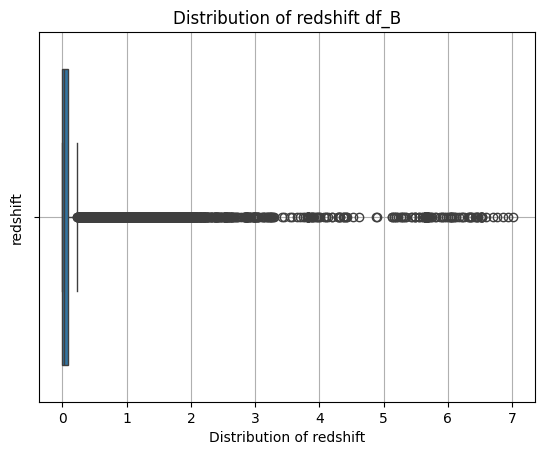

In [107]:
sns.boxplot(data=df_B, x="redshift")
plt.title("Distribution of redshift df_B")
plt.xlabel("Distribution of redshift")
plt.ylabel("redshift")
plt.grid()

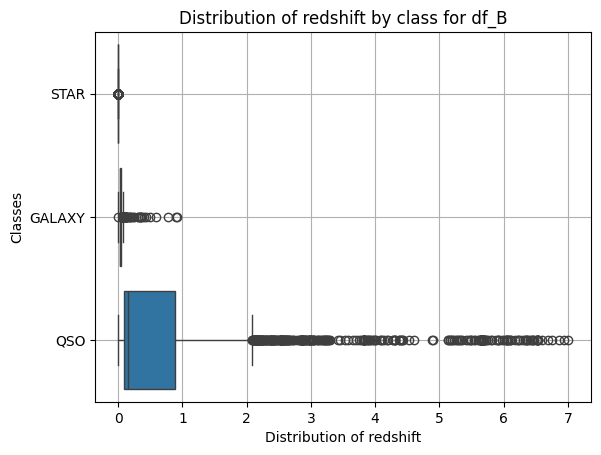

In [25]:
sns.boxplot(data=df_B, x="redshift", y="class")
plt.title("Distribution of redshift by class for df_B")
plt.xlabel("Distribution of redshift")
plt.ylabel("Classes")
plt.grid()

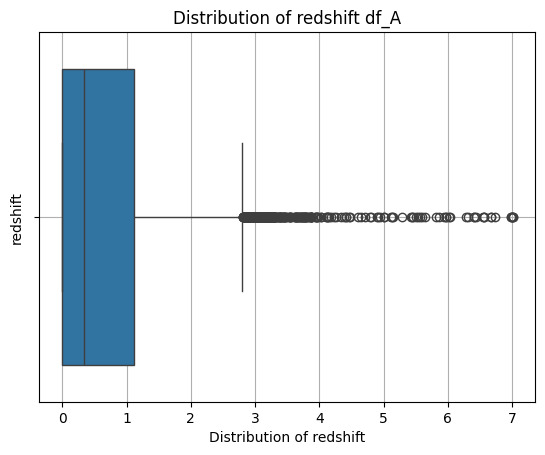

In [108]:
sns.boxplot(data=df_A, x="redshift")
plt.title("Distribution of redshift df_A")
plt.xlabel("Distribution of redshift")
plt.ylabel("redshift")
plt.grid()

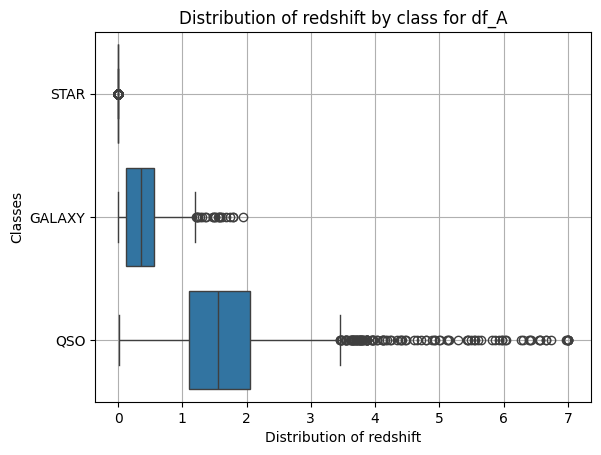

In [26]:
sns.boxplot(data=df_A, x="redshift", y="class")
plt.title("Distribution of redshift by class for df_A")
plt.xlabel("Distribution of redshift")
plt.ylabel("Classes")
plt.grid()

Comparing both the boxplots above, we can see that `df_B` that is ordered to have the brightest objects, appears to have a significantly larger number of outliers than `df_A`, that has objects with a range of magnitudes.

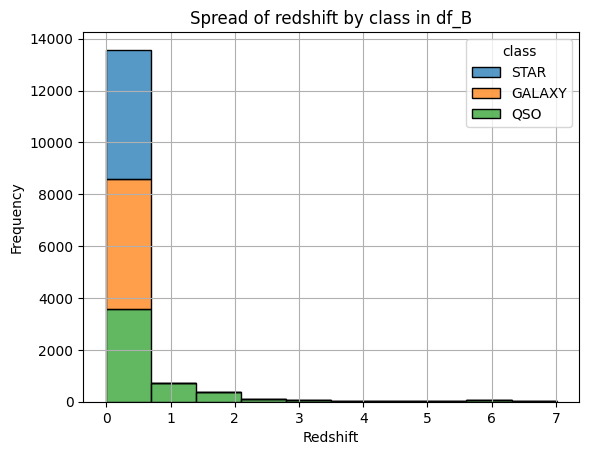

In [66]:
sns.histplot(data=df_B, x="redshift", hue="class", multiple="stack", bins=10)
plt.title("Spread of redshift by class in df_B")
plt.xlabel("Redshift")
plt.ylabel("Frequency")
plt.grid()

In [49]:
(df_B["redshift"] < 1.0).sum(), int((df_B["redshift"] < 1.0).sum())/df_B.shape[0] * 100

(np.int64(13910), 92.73333333333333)

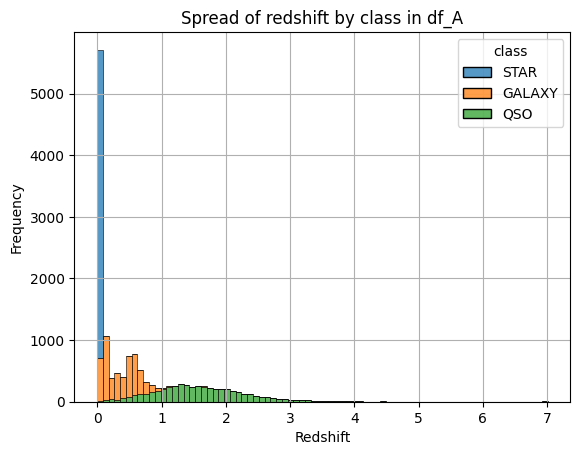

In [65]:
sns.histplot(df_A, x="redshift", hue="class", multiple="stack")
plt.title("Spread of redshift by class in df_A")
plt.xlabel("Redshift")
plt.ylabel("Frequency")
plt.grid()

In [48]:
(df_A["redshift"] < 1.0).sum(), int((df_A["redshift"] < 1.0).sum())/df_A.shape[0] * 100

(np.int64(10927), 72.84666666666666)

From the above visualizations, we need to understand that 1/3 of the values of redshift < 1.0 are for stars. So let us visualize the values for only galaxies and quasars.



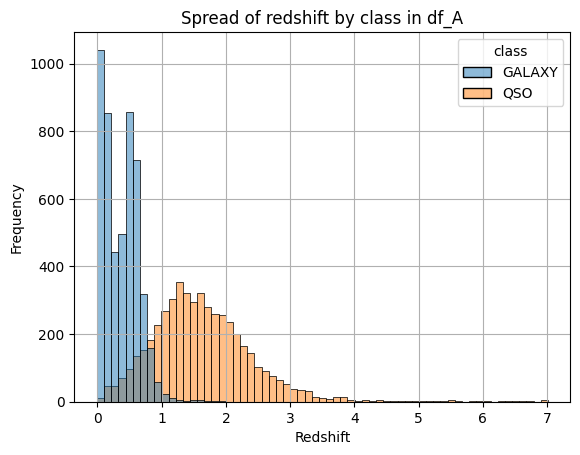

In [67]:
sns.histplot(df_A[(df_A["class"] == "GALAXY") | (df_A["class"] == "QSO")], x="redshift", hue="class")
plt.title("Spread of redshift by class in df_A")
plt.xlabel("Redshift")
plt.ylabel("Frequency")
plt.grid()

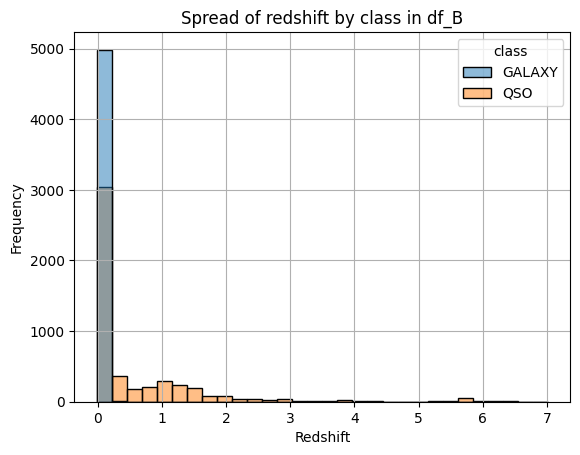

In [68]:
sns.histplot(df_B[(df_B["class"] == "GALAXY") | (df_B["class"] == "QSO")], x="redshift", hue="class", bins=30)
plt.title("Spread of redshift by class in df_B")
plt.xlabel("Redshift")
plt.ylabel("Frequency")
plt.grid()

In [62]:
((df_B["redshift"] < 1.0) & (df_B["class"] == "GALAXY")).sum()

np.int64(5000)

In [63]:
((df_A["redshift"] < 1.0) & (df_A["class"] == "GALAXY")).sum()

np.int64(4949)

Alright! Now we have a more clearer picture. There are a lot more objects in `df_B` with lower redshifts; the amount of fainter objects in df_B by only observing the redshifts is higher compared to `df_A`, which has a substantial spread not leaning towards bright or fainter objects.



---

Let's analyse the `r` magnitude in both the datasets.

## 2. Analyse **r magnitude** across both the datasets

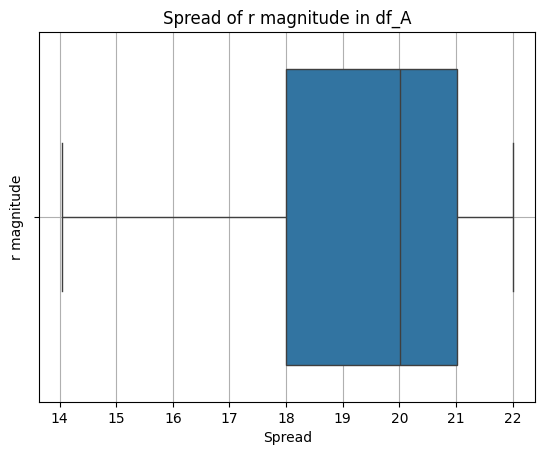

In [71]:
sns.boxplot(data=df_A, x="r")
plt.title("Spread of r magnitude in df_A")
plt.xlabel("Spread")
plt.ylabel("r magnitude")
plt.grid()

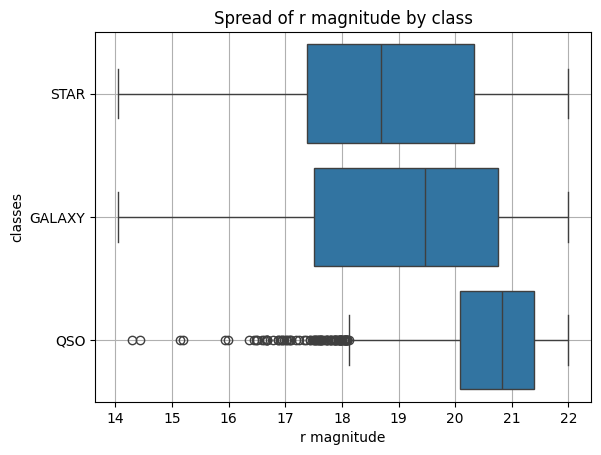

In [69]:
sns.boxplot(data=df_A, x="r", y="class")
plt.title("Spread of r magnitude by class")
plt.xlabel("r magnitude")
plt.ylabel("classes")
plt.grid()

It appears that the **`r` magnitude** in df_A is more concentrated towards relatively brighter objects, but are not too bright or extremely faint.

However, when viewing boxplots for individual classes, it appears that quasars (`QSO`) tends to have a number of outliers, significantly constituting faintly observed quasars which might be unresolved.

Let us analyse the same for `df_B`.

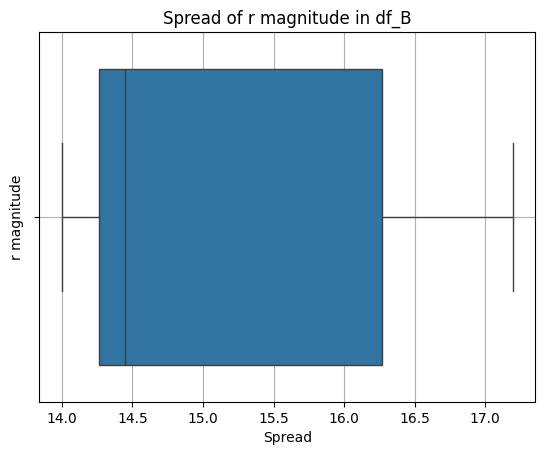

In [72]:
sns.boxplot(data=df_B, x="r")
plt.title("Spread of r magnitude in df_B")
plt.xlabel("Spread")
plt.ylabel("r magnitude")
plt.grid()

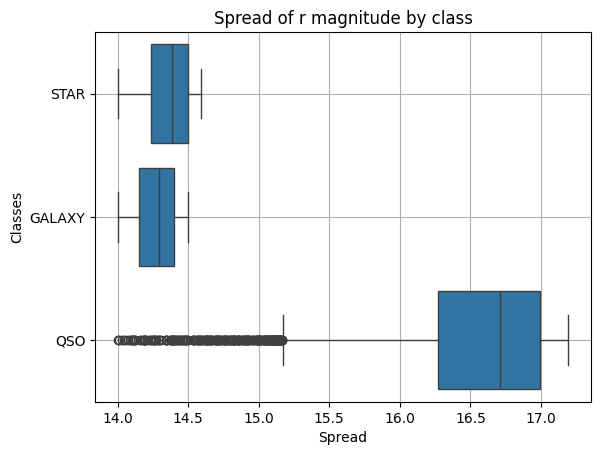

In [73]:
sns.boxplot(data=df_B, x="r", y="class")
plt.title("Spread of r magnitude by class")
plt.xlabel("Spread")
plt.ylabel("Classes")
plt.grid()

From the above visualizations of the **`r` magnitude** in `df_A`, we can see that the concentration is more focused towards less brighter or fainter objects, with the upper bound being at roughly around 17.1.

When observing the boxplots by classes, we can see that quasars tend to be more brighter stars and galaxies are significantly far behind. Along with that, quasars also have a significant number of outliers, indicating the presence of faint or unresolved quasars.

Let us construct histograms and analyse the `r` magnitude.

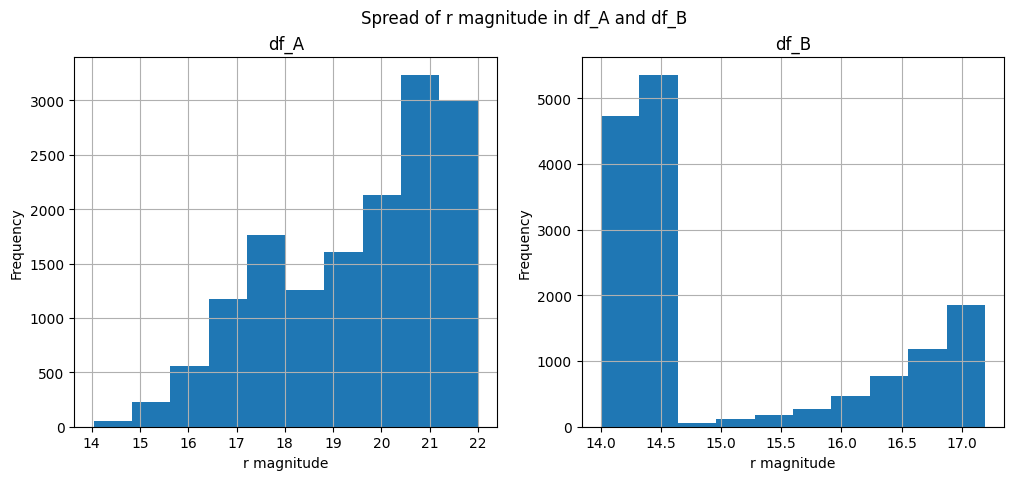

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Spread of r magnitude in df_A and df_B")
fig.set_figwidth(12)

ax1.hist(x=df_A["r"], label="df_A")
ax1.set_title("df_A")
ax1.set(xlabel="r magnitude", ylabel="Frequency")
ax1.grid()

ax2.hist(x=df_B["r"], label="df_B")
ax2.set_title("df_B")
ax2.set(xlabel="r magnitude", ylabel="Frequency")
ax2.grid()

From the above plots, we can see that the spread of `r` magnitude in df_A, though left skewed, has a proportionally spread landscape, even though the majority of the values fall towards the brighter side.

On the other hand, df_B has `r` magnitude significantly leaning more towards fainter objects.

Let us analyse it now classwise.

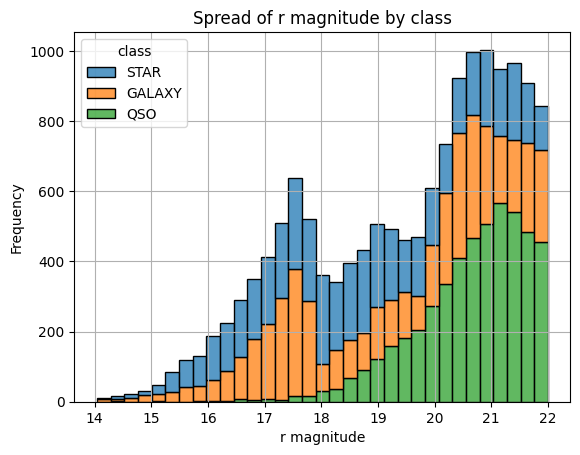

In [89]:
sns.histplot(data=df_A, x="r", hue="class", multiple="stack")
plt.title("Spread of r magnitude by class")
plt.xlabel("r magnitude")
plt.ylabel("Frequency")
plt.grid()

From the above plot, we can see that the spread of `r` magnitude for quasars is higher than that of galaxies, which is higher than that of stars.

* Between 17.9 to 20.8, the `r` magnitude for galaxies tends to be lesser than that for stars. On the left and right of that, the value for galaxies is greater than that of stars.

* Quasars tend to have the values concentrated towards the higher end. However, there are outliers as observed before in the boxplots.

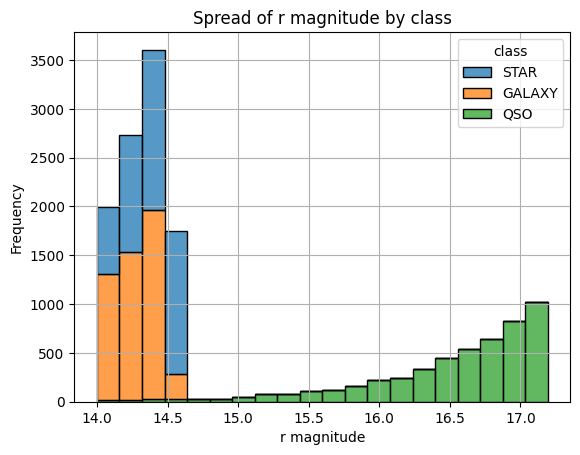

In [90]:
sns.histplot(data=df_B, x="r", hue="class", multiple="stack")
plt.title("Spread of r magnitude by class")
plt.xlabel("r magnitude")
plt.ylabel("Frequency")
plt.grid()

From the above plot, we can see that the spread of `r` magnitude for stars and quasars tend to be concentrated more towards the lower end while that of quasars is towards the higher end.

* Between 14.0 and 14.5 lie the major concentration of values for stars and galxies, with that of galaxies decreasing as we move towards 14.5.

* For quasars, they start typically around 15.0 but have concentrations even towards the lower end of values.

We will use a scatter plot to plot all the points by `r` and `redshift` and observe them.

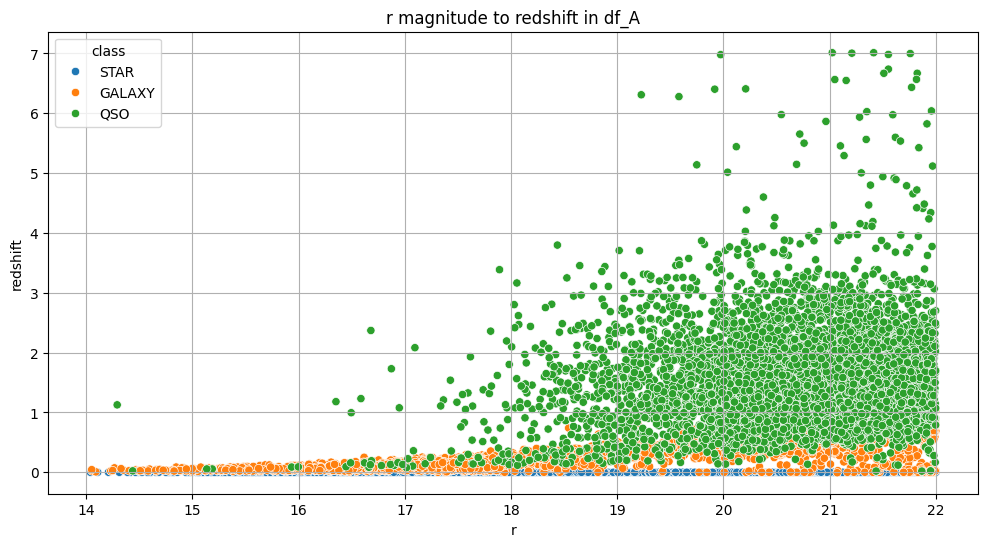

In [103]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_A, x="r", y="redshift", hue="class")
plt.title("r magnitude to redshift in df_A")
plt.grid()

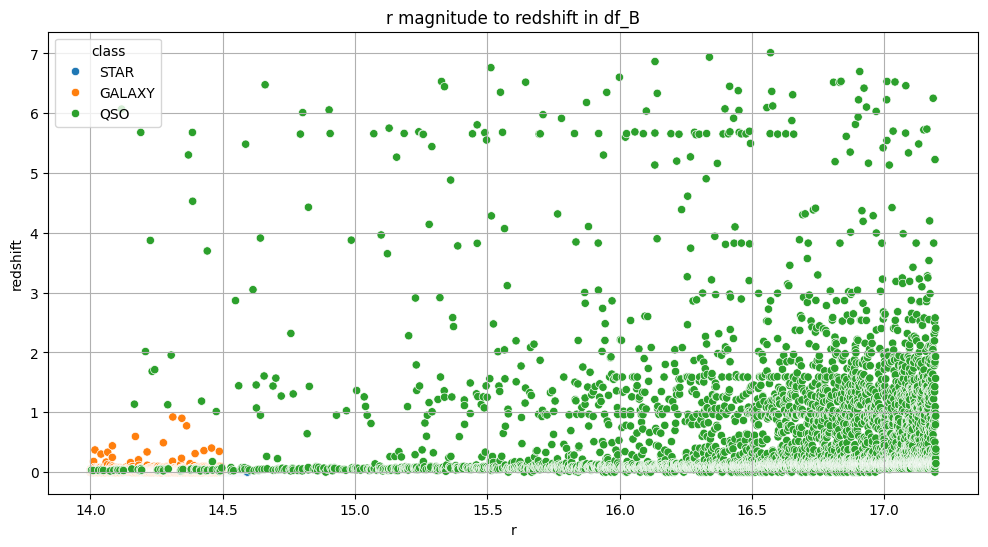

In [105]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_B, x="r", y="redshift", hue="class")
plt.title("r magnitude to redshift in df_B")
plt.grid()

So here, we can clearly see that `df_B` is more concentrated with objects that are less brigther or faint compared to `df_A` which is more evenly spread in the `r` magnitude.

We will confirm this with one hypothesis test to statistically prove our assumptions from the above EDA.

## 3. Conduct hypothesis tests

We have observed the following from our EDA above:

* **`redshift`** in `df_A` that though a large concentration lies in the 75th percentile, it is evenly spread out compared to `df_B`, who's concentration almost entirely lies in median, with a significantly larger number of outliers compared to `df_A`.

* **`r magnitude`** in `df_A` is more evenly spread out, with a range of different objects with varied brightness compared to `df_B`, where the brightest objects are quasars which are located in the higher end while stars and galaxies are towards the lower bound with an uneven spread of values.

Therefore, the goal of this section is to confirm our assumptions about the data. Namely we need to confirm:

1. Whether the mean `redshift` of `df_A` is greater than the mean `redshift` of `df_B`, confirming that `redshift` is more evely spread out across `df_A`.
2. Whether the mean `r magnitude` of `df_A` is greater than the mean `r magnitude` of `df_B`, confirming that `r magnitude` is more evely spread out across `df_A`.

For this, we will conduct two hypothesis tests. The significance level will be set to $5\%$.

In [20]:
# significance level
sig_level = 0.05

***Hypothesis Test 1:*** The mean redshift of `df_A` is greater than the mean redshift of `df_B`.

$H_0:$ The mean `redshift` in both the datasets are equal or nearly identical.

$H_1:$ The mean `redshift` of `df_A` is greater than the mean `redshift` of `df_B`.

In [10]:
df_A_redshift = df_A["redshift"]
df_B_redshift = df_B["redshift"]

len(df_A_redshift), len(df_B_redshift)

(15000, 15000)

In [19]:
stats.shapiro(df_A_redshift)

ShapiroResult(statistic=np.float64(0.7809703687448344), pvalue=np.float64(4.921356955511569e-88))

In [21]:
stats.shapiro(df_B_redshift)

ShapiroResult(statistic=np.float64(0.34745972938491376), pvalue=np.float64(1.880785806002697e-115))

We can very clearly see that the data is not normally distributed. Therefore, we will use the permutation test with a custom statistic.

In [8]:
def mean_diff(a, b):
  return np.mean(a) - np.mean(b)

In [11]:
data = (df_A_redshift, df_B_redshift)

In [12]:
p_val_h1 = stats.permutation_test(
    data,
    statistic=mean_diff,
    permutation_type="independent",
    n_resamples=5000,
    alternative="two-sided",
    random_state=42
)

In [22]:
p_val_h1.pvalue < sig_level, p_val_h1.pvalue

(np.True_, np.float64(0.0003999200159968006))

From the above test, we can see that the p value is less than the significance level. Therefore, we can reject our null hypothesis and confirm that the mean `redshift` of `df_A` is greater than the mean `redshift` of `df_B`.

***Hypothesis Test 2:*** The mean r magnitude of `df_A` is greater than the mean r magnitude of `df_B`

$H_0:$ The mean r magnitude of both the datasets is equal or nearly identical.

$H_1:$ The mean r magnitude of `df_A` is greater than the mean r magnitude of `df_B`.

In [23]:
r_mag_dfA = df_A["r"]
r_mag_dfB = df_B["r"]

In [23]:
stats.shapiro(r_mag_dfA)

ShapiroResult(statistic=np.float64(0.9344702002296477), pvalue=np.float64(4.0136515653433904e-62))

In [25]:
stats.shapiro(r_mag_dfB)

ShapiroResult(statistic=np.float64(0.7476424920222664), pvalue=np.float64(2.228716060902753e-91))

The data is not normally distributed!

In [24]:
p_val_h2 = stats.permutation_test(
    (r_mag_dfA, r_mag_dfB),
    statistic=mean_diff,
    permutation_type="independent",
    alternative="two-sided",
    n_resamples=5000,
    random_state=42
)
p_val_h2.pvalue < sig_level, p_val_h2.pvalue

(np.True_, np.float64(0.0003999200159968006))

From the above state, we can see that the pvalue is less than the significance level. Therefore, we can reject the null hypothesis and confirm that the mean `r_magnitude` of `df_A` is greater than that of `df_B`.

## Final Thoughts

From all the above EDA and statistical tests, we can see that the values significant for our modelling experiments are more spread out and have less noise in `df_A`. The values of `redshift` and `r` magnitude were key determinants in these tests. Therefore, for our modelling we will go ahead with the first dataset sample.